#**<big><big>Computación y Estructuras Discretas III</big></big><br><small>Depto. Computación y Sistemas Inteligentes / Facultad de Ingeniería</small><br><small>_Segunda Tarea Integradora_ ( Dense Neural Networks, Recurrent Neural Networks (RNN), and Long Short-Term Memory (LSTM) ). </small>**

---

###Dylan Bermúdez Cardona - **A00381287**
###Juan David Calderón Salamanca - **A00395803**
###Santiago Escobar León - **A00382203**

In [49]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import keras
from keras.layers import BatchNormalization
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, GlobalAveragePooling1D
from keras.models import Model
import tensorflow as tf
from keras.layers import Input, Embedding, LSTM, Dense, Activation, Dropout, Bidirectional
from keras.regularizers import l2
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# EDA

In [42]:
data = pd.read_csv('fakenews.csv')
data

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


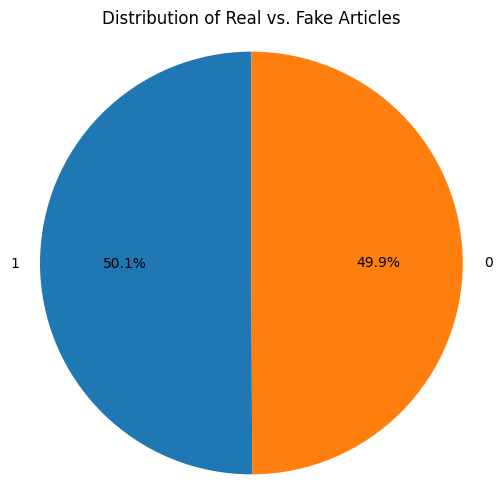

In [74]:
# @title Distribution of Real vs. Fake Articles

import matplotlib.pyplot as plt

labels = data['label'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(labels, labels=labels.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Real vs. Fake Articles')
_ = plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

In [83]:
data.shape

(20761, 6)

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20761 entries, 0 to 20799
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              20761 non-null  int64 
 1   title           20203 non-null  object
 2   author          18843 non-null  object
 3   text            20761 non-null  object
 4   label           20761 non-null  int64 
 5   processed_text  20761 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.1+ MB


In [85]:
data.describe()

,id,label
count,20761.000000,20761.000000
mean,10401.130341,0.499687
std,6005.142716,0.500012
min,0.000000,0.000000
25%,5201.000000,0.000000
50%,10401.000000,0.000000
75%,15603.000000,1.000000
max,20799.000000,1.000000


In [76]:
data.isnull().sum()

id                   0
title              558
author            1957
text                39
label                0
processed_text       0
dtype: int64

In [77]:
data.dropna(subset=['text'], inplace=True)

In [78]:
data.isnull().sum()

id                   0
title              558
author            1918
text                 0
label                0
processed_text       0
dtype: int64

# Preprocess text

In [43]:
import nltk
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_tokens)

data['processed_text'] = data['text'].apply(lambda x: preprocess_text(str(x)))

X_train, X_test, y_train, y_test = train_test_split(data['processed_text'], data['label'], test_size=0.2, random_state=42)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [44]:
max_words = 10000
max_length = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

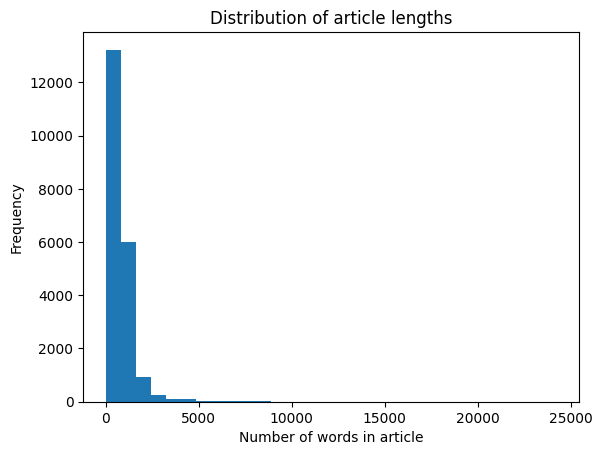

Total number of unique words in the dataset: 491505
Top 10 most common words: [('the', 813459), ('to', 418509), ('of', 414147), ('and', 360716), ('a', 343106), ('in', 278907), ('that', 195915), ('is', 150340), ('for', 135699), ('on', 120956)]


In [82]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


article_lengths = data['text'].astype(str).apply(lambda x: len(x.split()))
plt.hist(article_lengths, bins=30)
plt.xlabel('Number of words in article')
plt.ylabel('Frequency')
plt.title('Distribution of article lengths')
plt.show()


all_words = ' '.join(data['text'].astype(str)).split() 
word_counts = Counter(all_words)
unique_words = len(word_counts)

print(f'Total number of unique words in the dataset: {unique_words}')
print(f'Top 10 most common words: {word_counts.most_common(10)}')

# Dummy classifier

In [45]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_history = dummy_clf.fit(X_train_padded, y_train)
y_pred_dummy = dummy_clf.predict(X_test_padded)

print("Dummy Model Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_dummy))
print("Precision:", precision_score(y_test, y_pred_dummy))
print("Recall:", recall_score(y_test, y_pred_dummy))
print("F1 Score:", f1_score(y_test, y_pred_dummy))

Dummy Model Metrics:
Accuracy: 0.4875
Precision: 0.4875
Recall: 1.0
F1 Score: 0.6554621848739496


# DNN

In [46]:
dense_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_length),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

dense_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

dense_history = dense_model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_split=0.2)
y_pred_dense = (dense_model.predict(X_test_padded) > 0.5).astype("int32")

print("Dense NN Model Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_dense))
print("Precision:", precision_score(y_test, y_pred_dense))
print("Recall:", recall_score(y_test, y_pred_dense))
print("F1 Score:", f1_score(y_test, y_pred_dense))
print("Kappa:", cohen_kappa_score(y_test, y_pred_dense))

Epoch 1/10


C:\Users\David\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8113 - loss: 0.4566 - val_accuracy: 0.9096 - val_loss: 0.2159
Epoch 2/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9586 - loss: 0.1287 - val_accuracy: 0.9102 - val_loss: 0.2368
Epoch 3/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9846 - loss: 0.0592 - val_accuracy: 0.9069 - val_loss: 0.3080
Epoch 4/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9939 - loss: 0.0320 - val_accuracy: 0.9029 - val_loss: 0.3427
Epoch 5/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9937 - loss: 0.0241 - val_accuracy: 0.9053 - val_loss: 0.4034
Epoch 6/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9965 - loss: 0.0161 - val_accuracy: 0.9041 - val_loss: 0.4483
Epoch 7/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9973 - loss: 0.0101 - val_accuracy: 0.9029 - val_loss: 0.4906
Epoch 8/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9973 - loss: 0.0106 - val_accuracy: 0.903

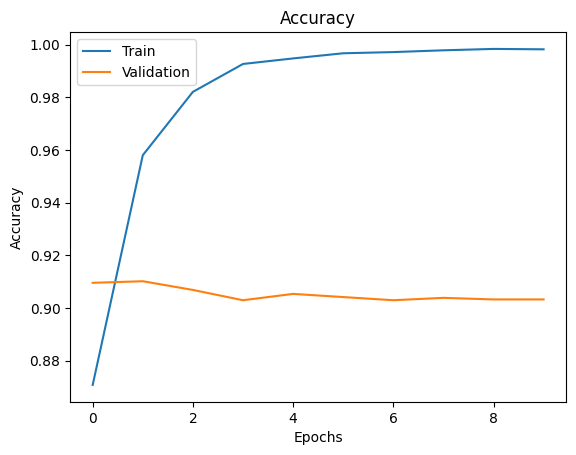

In [68]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(dense_history.history['accuracy'],label="Train");
plt.plot(dense_history.history['val_accuracy'],label="Validation");
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show();

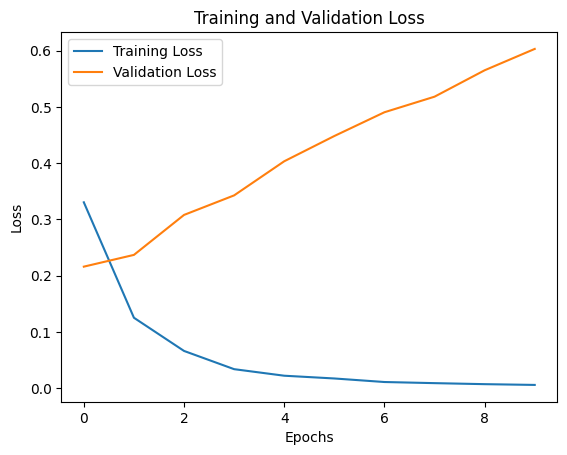

In [69]:
import matplotlib.pyplot as plt

# Graficar la pérdida de entrenamiento y validación
plt.plot(dense_history.history['loss'], label='Training Loss')
plt.plot(dense_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
param_grid = {
    'batch_size': [10, 20],
    'epochs': [10, 20],
    'optimizer': ['adam', 'rmsprop']
}

In [66]:
model1 = KerasClassifier(build_fn=dense_model, verbose=0)
grid1 = GridSearchCV(estimator=model1, param_grid=param_grid, n_jobs=-1, cv=5) 
grid_result1 = grid1.fit(X_train_padded, y_train) 

C:\Users\David\AppData\Roaming\Python\Python312\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


In [ ]:
print(f"Best: {grid_result1.best_score_} using {grid_result1.best_params_}")

Best: 0.9392427884615385 using {'batch_size': 20, 'epochs': 10, 'optimizer': 'rmsprop'}


In [67]:
best_model1 = grid_result1.best_estimator_
y_pred1 = best_model1.predict(X_train_padded)


accuracyRecurrentNN_best1 = accuracy_score(y_train, y_pred1)
precisionRecurrentNN_best1 = precision_score(y_train, y_pred1)
recallRecurrentNN_best1 = recall_score(y_train, y_pred1)
f1RecurrentNN_best1 = f1_score(y_train, y_pred1)
kappaRecurrentNN_best1 = cohen_kappa_score(y_train, y_pred1)

print(f"DNN - Accuracy: {accuracyRecurrentNN_best1:.4f}, Precision: {precisionRecurrentNN_best1:.4f}, Recall: {recallRecurrentNN_best1:.4f}, F1: {f1RecurrentNN_best1:.4f}, Kappa: {kappaRecurrentNN_best1:.4f}")

DNN - Accuracy: 0.9993, Precision: 0.9995, Recall: 0.9990, F1: 0.9993, Kappa: 0.9986


# RNN

In [52]:
rnn_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_length),
    Dropout(0.2),
    SimpleRNN(64, return_sequences=False),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

rnn_history = rnn_model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_split=0.2)
y_pred_rnn = (rnn_model.predict(X_test_padded) > 0.5).astype("int32")

print("RNN Model Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_rnn))
print("Precision:", precision_score(y_test, y_pred_rnn))
print("Recall:", recall_score(y_test, y_pred_rnn))
print("F1 Score:", f1_score(y_test, y_pred_rnn))
print("Kappa:", cohen_kappa_score(y_test, y_pred_rnn))

Epoch 1/10


C:\Users\David\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


416/416 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.7676 - loss: 0.4514 - val_accuracy: 0.9093 - val_loss: 0.2466
Epoch 2/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9706 - loss: 0.0916 - val_accuracy: 0.8903 - val_loss: 0.2660
Epoch 3/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9875 - loss: 0.0406 - val_accuracy: 0.8789 - val_loss: 0.3643
Epoch 4/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9984 - loss: 0.0082 - val_accuracy: 0.8783 - val_loss: 0.4129
Epoch 5/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9993 - loss: 0.0036 - val_accuracy: 0.9029 - val_loss: 0.4058
Epoch 6/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9981 - loss: 0.0077 - val_accuracy: 0.8323 - val_loss: 0.5476
Epoch 7/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9920 - loss: 0.0271 - val_accuracy: 0.8954 - val_loss: 0.4604
Epoch 8/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9869 - loss: 0.0346 - val_accuracy: 0.85

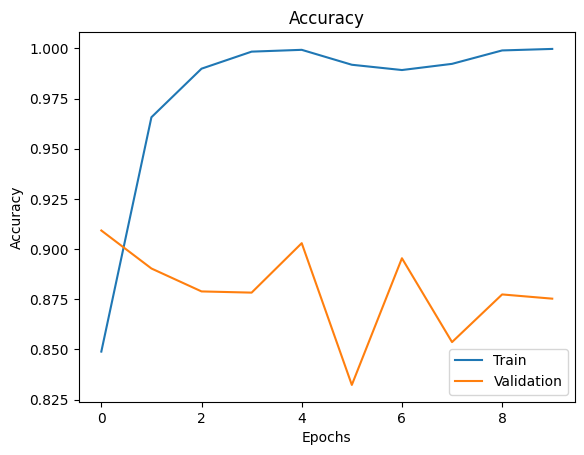

In [70]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(rnn_history.history['accuracy'],label="Train");
plt.plot(rnn_history.history['val_accuracy'],label="Validation");
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show();

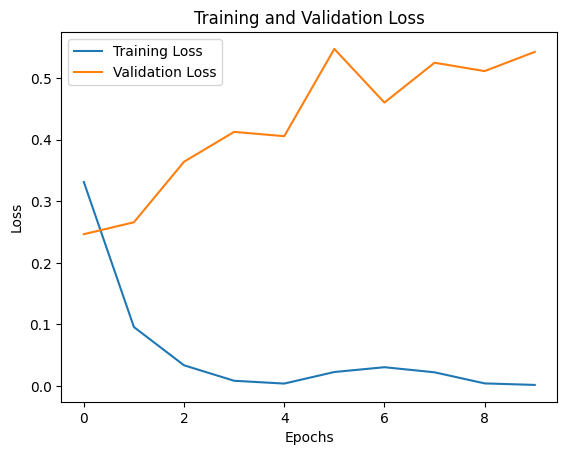

In [71]:
import matplotlib.pyplot as plt

plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [54]:
model = KerasClassifier(build_fn=rnn_model, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5) 
grid_result = grid.fit(X_train_padded, y_train) 

C:\Users\David\AppData\Roaming\Python\Python312\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


In [56]:
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

Best: 0.9245192307692308 using {'batch_size': 20, 'epochs': 10, 'optimizer': 'adam'}


In [60]:
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_train_padded)


accuracyRecurrentNN_best = accuracy_score(y_train, y_pred)
precisionRecurrentNN_best = precision_score(y_train, y_pred)
recallRecurrentNN_best = recall_score(y_train, y_pred)
f1RecurrentNN_best = f1_score(y_train, y_pred)
kappaRecurrentNN_best = cohen_kappa_score(y_train, y_pred)

print(f"RNN - Accuracy: {accuracyRecurrentNN_best:.4f}, Precision: {precisionRecurrentNN_best:.4f}, Recall: {recallRecurrentNN_best:.4f}, F1: {f1RecurrentNN_best:.4f}, Kappa: {kappaRecurrentNN_best:.4f}")

RNN - Accuracy: 0.9986, Precision: 0.9982, Recall: 0.9989, F1: 0.9986, Kappa: 0.9971


# LSTM

In [62]:
lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_length),
    LSTM(64, return_sequences=False),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

lstm_history = lstm_model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_split=0.2)
y_pred_lstm = (lstm_model.predict(X_test_padded) > 0.5).astype("int32")

print("LSTM Model Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_lstm))
print("Precision:", precision_score(y_test, y_pred_lstm))
print("Recall:", recall_score(y_test, y_pred_lstm))
print("F1 Score:", f1_score(y_test, y_pred_lstm))
print("Kappa:", cohen_kappa_score(y_test, y_pred_lstm))

Epoch 1/10


C:\Users\David\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


416/416 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.8310 - loss: 0.3825 - val_accuracy: 0.9195 - val_loss: 0.2016
Epoch 2/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.9663 - loss: 0.0959 - val_accuracy: 0.9056 - val_loss: 0.2317
Epoch 3/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.9889 - loss: 0.0412 - val_accuracy: 0.9129 - val_loss: 0.2949
Epoch 4/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.9942 - loss: 0.0206 - val_accuracy: 0.9093 - val_loss: 0.3487
Epoch 5/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.9952 - loss: 0.0163 - val_accuracy: 0.9126 - val_loss: 0.4125
Epoch 6/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.9982 - loss: 0.0088 - val_accuracy: 0.9047 - val_loss: 0.4730
Epoch 7/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.9965 - loss: 0.0119 - val_accuracy: 0.8963 - val_loss: 0.4956
Epoch 8/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.9939 - loss: 0.0186 - val_accurac

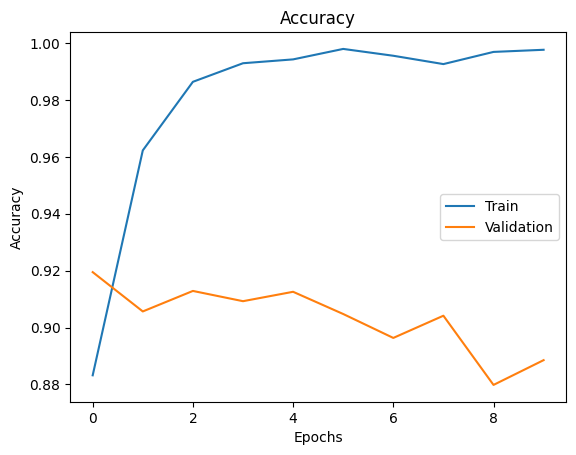

In [72]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(lstm_history.history['accuracy'],label="Train");
plt.plot(lstm_history.history['val_accuracy'],label="Validation");
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show();

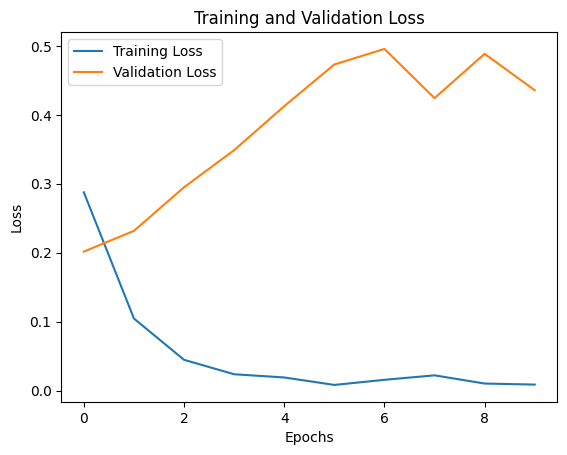

In [73]:
import matplotlib.pyplot as plt

plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [63]:
model2 = KerasClassifier(build_fn=lstm_model, verbose=0)
grid2 = GridSearchCV(estimator=model2, param_grid=param_grid, n_jobs=-1, cv=5) 
grid_result2 = grid2.fit(X_train_padded, y_train)  

C:\Users\David\AppData\Roaming\Python\Python312\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


In [64]:
print(f"Best: {grid_result2.best_score_} using {grid_result2.best_params_}")

Best: 0.9665865384615385 using {'batch_size': 20, 'epochs': 10, 'optimizer': 'adam'}


In [65]:
best_model2 = grid_result2.best_estimator_
y_pred2 = best_model2.predict(X_train_padded)


accuracyRecurrentNN_best2 = accuracy_score(y_train, y_pred2)
precisionRecurrentNN_best2 = precision_score(y_train, y_pred2)
recallRecurrentNN_best2 = recall_score(y_train, y_pred2)
f1RecurrentNN_best2 = f1_score(y_train, y_pred)
kappaRecurrentNN_best2 = cohen_kappa_score(y_train, y_pred2)

print(f"LSTM - Accuracy: {accuracyRecurrentNN_best2:.4f}, Precision: {precisionRecurrentNN_best2:.4f}, Recall: {recallRecurrentNN_best2:.4f}, F1: {f1RecurrentNN_best2:.4f}, Kappa: {kappaRecurrentNN_best2:.4f}")

LSTM - Accuracy: 0.9999, Precision: 0.9999, Recall: 0.9999, F1: 0.9986, Kappa: 0.9998
